In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
random.seed(42)

%matplotlib inline

In [31]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [32]:
len(words)

32033

In [33]:
start_end_char = '.'

chars = sorted(list(set(''.join(words))))

# Create a mapping from character to index
stoi = {s:i+1 for i, s in enumerate(chars)}
# Add a start and end token
stoi[start_end_char] = 0

# Create a mapping from index to character
itos = {k:s for s, k in stoi.items()}
vocab_size = len(stoi)

stoi, itos, vocab_size

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'},
 27)

In [34]:
# Building the dataset

# context length: how many characters to look at to predict the next one
block_size = 3

def dataset_builder(words):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * block_size
        for c in word + start_end_char:
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), '--->', c)
            context = context[1:] + [ix] # crop the first element and add the new one

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # print(X.shape, Y.shape)
    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X, Y = dataset_builder(words[:n1]) # 80% of the data
X_val, Y_val = dataset_builder(words[n1:n2]) # 10% of the data
X_test, Y_test = dataset_builder(words[n2:]) # 10% of the data

The 5/3 gain in the $\tanh$ comes for the average value of $\tanh^2(x)$ where $x$ is distributed as a Gaussian, i.e.

We need to evaluate the integral of $\tanh^2⁡(x)$ weighted by a Gaussian distribution to get 5/3 gain.

1. Gaussian distribution:

$$f(x)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

In our case $\sigma=1$ and $\mu=0$

2. integrate $\tanh^2(x) \frac{e^{-x^2/2}}{\sqrt{2\pi}} \text{ from} -\infty \text{ to } \infty \approx  0.39$

$$\int_{-\infty}^{\infty} \frac{\tanh^2(x) e^{-x^2/2}}{\sqrt{2\pi}} dx = 0.394294$$

The output variance of $\tanh⁡(x)$ when the input $x$ has unit variance is thus 0.394

### Why Is This Integral Important?

* Variance Reduction: The integral helps us understand by how much the $\tanh$ function compresses the variance of the input. If $x$ has a variance of 1, the output $y=\tanh⁡(x)$ will have a reduced variance. The value of this integral gives us the factor by which the variance is reduced. Variance $(\sigma^2)$ is a measure of the spread of a set of values. It gives the average squared deviation from the mean. Standard deviation $(\sigma)$ is the square root of the variance and represents the average deviation from the mean. Since variance is reduced by a factor of 0.394, the standard deviation (which is the square root of variance) is reduced by: $\sqrt{0.39} \approx 0.63$. This means that if the input to the $\tanh⁡$ function has a variance of 1, the output will have a variance of 0.394 and a standard deviation of approximately 0.63

* Weight Initialization: To maintain the variance of the activations across layers in a neural network, we need to adjust the weights during initialization. If the variance is reduced by a factor 0.39 (as found from the integral), the standard deviation is reduced by $\sqrt{0.39} \approx 0.63$ To compensate for this reduction and ensure the variance remains close to 1, we scale the initial weights by a factor of $1/0.630 \approx 5/3$

### Compensating for Variance Reduction

To maintain the variance of activations close to 1 across layers, we need to counteract the reduction caused by the $\tanh⁡$ function. This is done by scaling the weights during initialization.

* Original Variance of Weights: If weights are initialized from a standard normal distribution $\mathcal{N}(0,1)$, the variance of the weights is 1.

* Desired Variance: To keep the variance of the activations consistent, we want the variance of the output of the $\tanh⁡$ function to remain 1.

* Scaling Factor: Given that the standard deviation is reduced to 0.63, we need to scale the weights by 1/0.63 to compensate.
This scaling factor ensures that the output variance remains 1 after applying the $\tanh⁡$ function.

Scaling Factor = 1/0.63 ≈ 1.59 ≈ 5/3

Dividing by the $\sqrt{\text{weights\_dim}}$ (also known as $\sqrt{\text{fan\_in}}$​) ensures that the variance of the initialized weights is appropriately scaled relative to the number of input dimensions. This is crucial for maintaining the stability of the activations variance.


In [35]:
# For reproducibility
g = torch.Generator().manual_seed(2147483647)

n_embd = 10
n_hidden = 200
weights_dim = block_size * n_embd

# Initialize the parameters
C = torch.randn((vocab_size, n_embd),       generator=g)

# Use the kaiming initialization to initialize W1
# https://arxiv.org/abs/1502.01852
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_
# tanh gain = 5/3
W1 = torch.randn((weights_dim, n_hidden),   generator=g) * (5/3) / (weights_dim**0.5) # * 0.2

# Batch normalization has a bias, so we don't need to initialize it
# b1 = torch.randn(n_hidden,                  generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size),    generator=g) * 0.01
b2 = torch.randn(vocab_size,                generator=g) * 0

# Batch normalization gain and bias
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters))

12097


tensor(0.0215) tensor(1.0032)
tensor(0.0029) tensor(0.9551)
0.3042903097250923


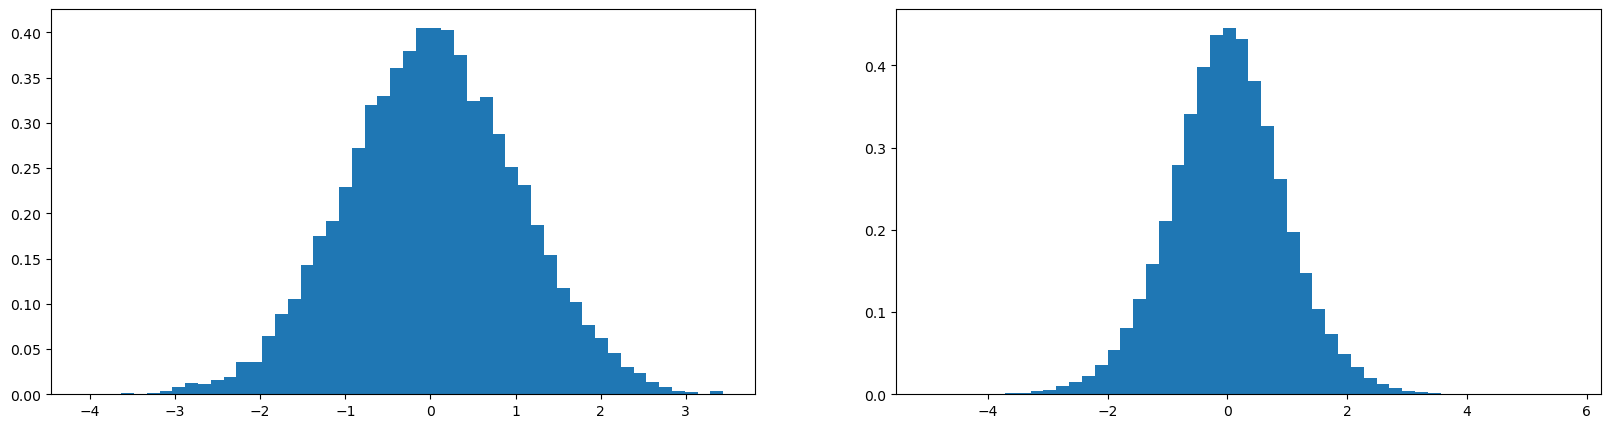

In [36]:
x = torch.randn(1000, 10)

# To prevent the expansion of the distribution divide by sqrt(number of dimension) or sqrt(fan_in)
w = torch.randn(10, 200) * (5/3) / (weights_dim**0.5)
# w = torch.randn(10, 200)

# When we use a dot product the standart deviation is growning
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

# The value of the kaiming initialization for tanh is 5/3
print((5/3) / (weights_dim**0.5))

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [37]:
max_steps, batch_size, lossi = 200000, 32, []

for i in range(max_steps):
    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    Xb, Yb = X[ix], Y[ix] # batch X, Y

    # Forward pass
    emb = C[Xb].view(-1, weights_dim)
    # Hidden layer preactivation, linear layer
    preact = emb @ W1 # + b1 

    # Batch normalization layer
    bnmeani = preact.mean(0, keepdim=True)
    bnstdi = preact.std(0, keepdim=True)

    preact = bngain * (preact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        # Every step we update the running mean and standard deviation slightly
        # At the end of the training we'll have approximately the same mean and standard deviation
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Add non-linearities
    h = torch.tanh(preact) # hidden representation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y[ix]) # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track the learning rate and the loss
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

print(loss.item())

      0/ 200000: 3.3022
  10000/ 200000: 2.3840
  20000/ 200000: 2.2264
  30000/ 200000: 2.2678
  40000/ 200000: 1.9528
  50000/ 200000: 2.1880
  60000/ 200000: 2.2642
  70000/ 200000: 2.0547
  80000/ 200000: 2.0878
  90000/ 200000: 1.8162
 100000/ 200000: 1.7928
 110000/ 200000: 1.8725
 120000/ 200000: 1.7822
 130000/ 200000: 2.0842
 140000/ 200000: 2.0503
 150000/ 200000: 2.2057
 160000/ 200000: 2.2908
 170000/ 200000: 2.1606
 180000/ 200000: 2.4403
 190000/ 200000: 2.0477
1.8098218441009521


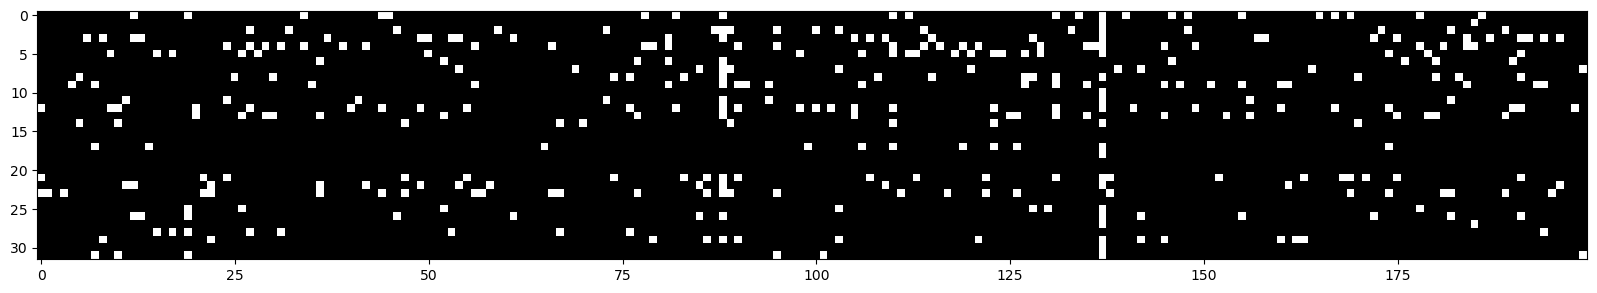

In [38]:
plt.figure(figsize=(20, 10))

# Check the saturation of the batch normalization
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

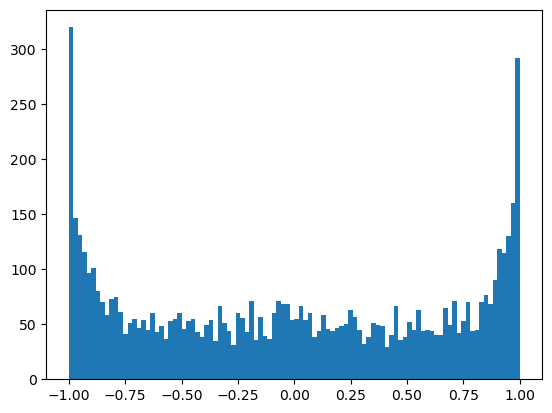

In [39]:
plt.hist(h.view(-1).tolist(), bins=100);

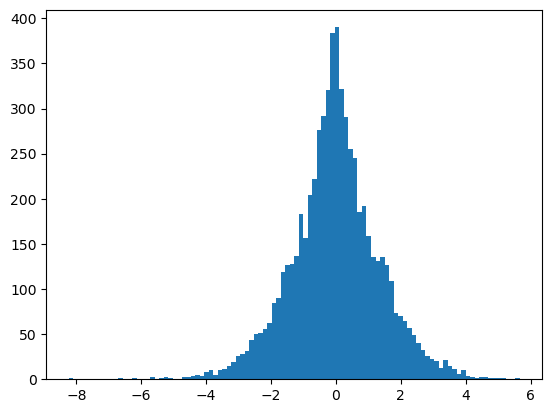

In [40]:
plt.hist(preact.view(-1).tolist(), bins=100);

In [41]:
# 4 dim example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [42]:
# Approximate default loss result for our model
-torch.tensor(1/27.0).log()

tensor(3.2958)

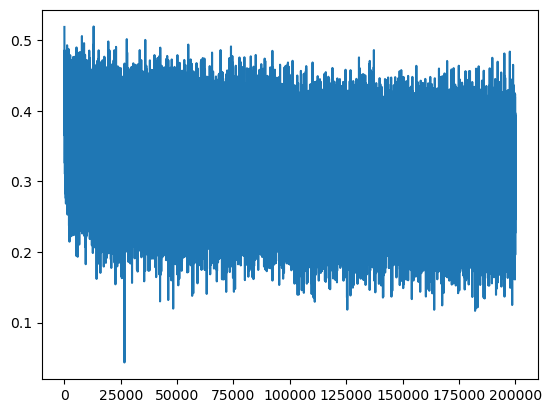

In [43]:
plt.plot(lossi)

In [44]:
# Calibraiting the batch normalization at the end of the training

with torch.no_grad():
    emb = C[X].view(-1, weights_dim)
    preact = emb @ W1 # + b1

    # Measure the mean and standard deviation of the batch
    bnmean = preact.mean(0, keepdim=True)
    bnstd = preact.std(0, keepdim=True)

# Compare with bnmean_running and bnstd_running
print(f"bnmean: {bnmean}, bnmean_running: {bnmean_running}")
print(f"bnstd: {bnstd}, bnstd_running: {bnstd_running}")

bnmean: tensor([[-1.7878,  0.6122, -2.1253,  1.2999,  1.2253,  0.4408,  1.0189, -1.1607,
          1.0947,  1.2884, -2.2104, -2.1574, -0.1736, -0.9717,  0.3698,  0.3563,
         -0.0483, -2.4536, -0.1987,  0.8792, -0.1536,  0.5018, -0.6580,  0.2449,
          1.4864,  0.7359,  0.7147, -0.6797,  1.3177,  1.8959, -0.4291, -0.2659,
          0.3433,  0.1521, -2.1854, -1.2519,  0.8859,  0.4108, -0.4736,  0.0897,
         -0.7574, -1.1496, -1.1521,  0.2528,  1.0585,  0.3143,  2.1882, -1.1762,
          1.3565,  1.5211,  1.6211, -0.0685,  1.8492,  0.1982,  0.9710, -2.6019,
         -1.5983,  0.8923,  1.8229, -0.9378, -0.8105,  1.3636,  0.7885,  0.6415,
          0.7326,  1.2993, -0.7555,  1.3851, -1.0927, -0.5212,  0.3329,  0.8782,
          0.1801, -1.6468, -2.4527,  0.1951,  1.2444,  0.3063,  0.6393,  0.5509,
          0.2763,  2.2457,  1.4179,  1.4613,  0.6270,  0.8224, -0.6526,  0.0864,
          1.7247, -0.0320, -0.4778,  1.4748, -0.3924, -0.4245, -0.7984,  0.1655,
          0.1113, -0

In [45]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X, Y),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x].view(-1, weights_dim)
    preact = emb @ W1 # + b1
    preact = bngain * (preact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y).item()

loss_train, loss_val = split_loss('train'), split_loss('val')
print(f'Train loss: {loss_train:.4f}, Val loss: {loss_val:.4f}')

Train loss: 2.0189, Val loss: 2.3168


In [46]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        # emb = C[torch.tensor([context])]
        emb = C[torch.tensor([context])].view(-1, weights_dim)

        preact = emb @ W1

        # Use bnmean_running and bnstd_running
        preact = bngain * (preact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(preact)
        logits = h @ W2 + b2

        # h = torch.tanh(emb.view(1, -1) @ W1) # + b1)
        # logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Update the context
        context = context[1:] + [ix]
        out.append(ix)
        # If we generated the end token, stop
        if ix == 0:
            break
    # Decode and print the generated word
    print(''.join([itos[i] for i in out[:-1]])) 

mora
mayah
see
madhayla
reisha
emdra
grace
korelin
shi
jen
eden
estana
leottimonte
cayshubergiha
jest
jaireth
kourteriffuna
gedi
jamyli
els


In [47]:
# Let's train a deep neural network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.randn((fan_out), generator=g) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # Update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


In [48]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make it less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # 5/3 is the gain of tanh for kaiming init

parameters = [C] + [p for layer in layers for p in layer.parameters()]

# same optimization as before
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47551


In [49]:
# Same optimization as before
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    Xb, Yb = X[ix], Y[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # if i == 1000:
    #     break

      0/ 200000: 3.3304
  10000/ 200000: 2.0667
  20000/ 200000: 1.9294
  30000/ 200000: 2.0772
  40000/ 200000: 2.4867
  50000/ 200000: 2.1311
  60000/ 200000: 1.9704
  70000/ 200000: 2.1902
  80000/ 200000: 1.9110
  90000/ 200000: 2.0495
 100000/ 200000: 2.0062
 110000/ 200000: 2.1037
 120000/ 200000: 2.2087
 130000/ 200000: 2.0230
 140000/ 200000: 2.0743
 150000/ 200000: 1.8935
 160000/ 200000: 2.2056
 170000/ 200000: 1.9801
 180000/ 200000: 1.9479
 190000/ 200000: 1.7875


layer 2 Tanh: mean 0.02, std 0.69, saturation 13.50%
layer 5 Tanh: mean -0.01, std 0.73, saturation 17.47%
layer 8 Tanh: mean -0.01, std 0.76, saturation 15.38%
layer 11 Tanh: mean -0.01, std 0.77, saturation 16.19%
layer 14 Tanh: mean 0.00, std 0.78, saturation 19.78%


Text(0.5, 1.0, 'Activation distribution')

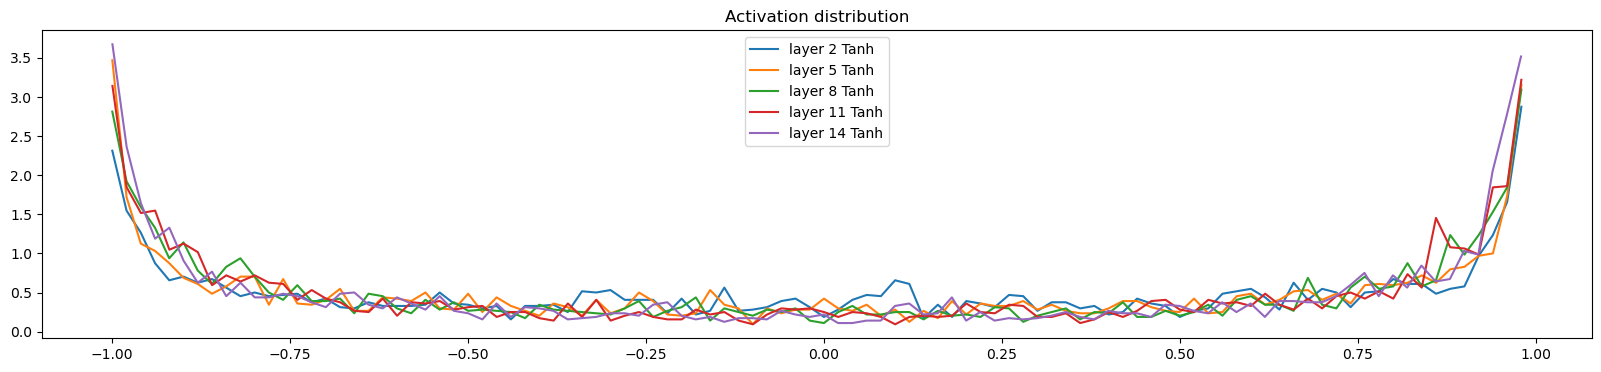

In [50]:
# Visualize histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean():.2f}, std {t.std():.2f}, saturation {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

plt.legend(legends)
plt.title("Activation distribution")

layer 2 Tanh: mean 0.00, std 0.00, saturation 0.00%
layer 5 Tanh: mean -0.00, std 0.00, saturation 0.00%
layer 8 Tanh: mean 0.00, std 0.00, saturation 0.00%
layer 11 Tanh: mean -0.00, std 0.00, saturation 0.00%
layer 14 Tanh: mean -0.00, std 0.00, saturation 0.00%


Text(0.5, 1.0, 'Gradient distribution')

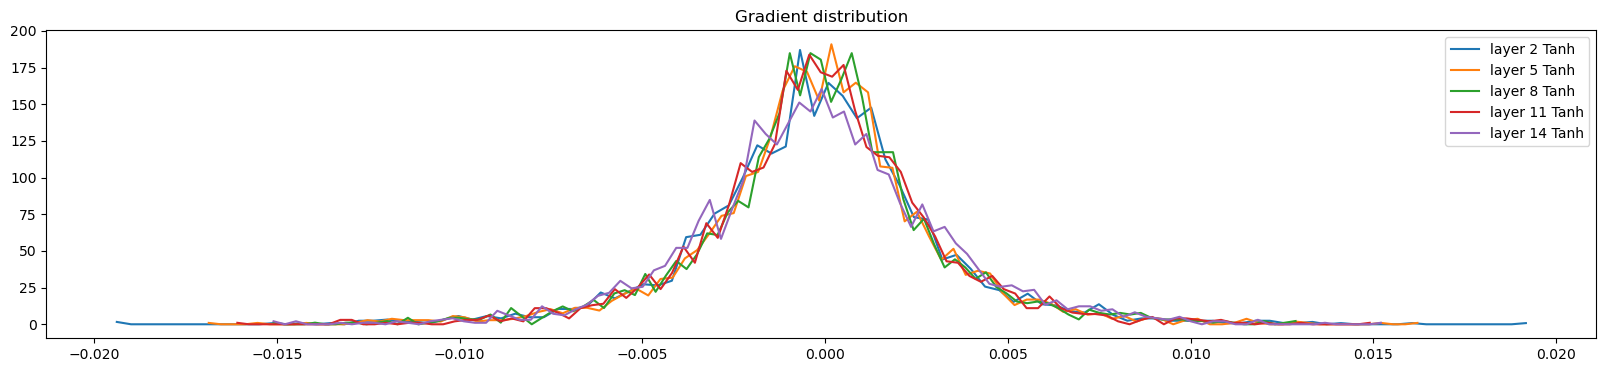

In [51]:
# Visualize histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean():.2f}, std {t.std():.2f}, saturation {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

plt.legend(legends)
plt.title("Gradient distribution")

weight   (27, 10) | mean +0.000000 | std 1.473157e-02 | grad:data ratio 1.344985e-02
weight  (30, 100) | mean -0.000018 | std 7.596784e-03 | grad:data ratio 1.850514e-02
weight (100, 100) | mean -0.000127 | std 4.967763e-03 | grad:data ratio 2.007028e-02
weight (100, 100) | mean +0.000003 | std 5.049861e-03 | grad:data ratio 2.073494e-02
weight (100, 100) | mean -0.000110 | std 4.751137e-03 | grad:data ratio 1.999211e-02
weight (100, 100) | mean -0.000009 | std 4.303551e-03 | grad:data ratio 1.873920e-02
weight  (100, 27) | mean -0.000194 | std 7.347884e-03 | grad:data ratio 2.231224e-02


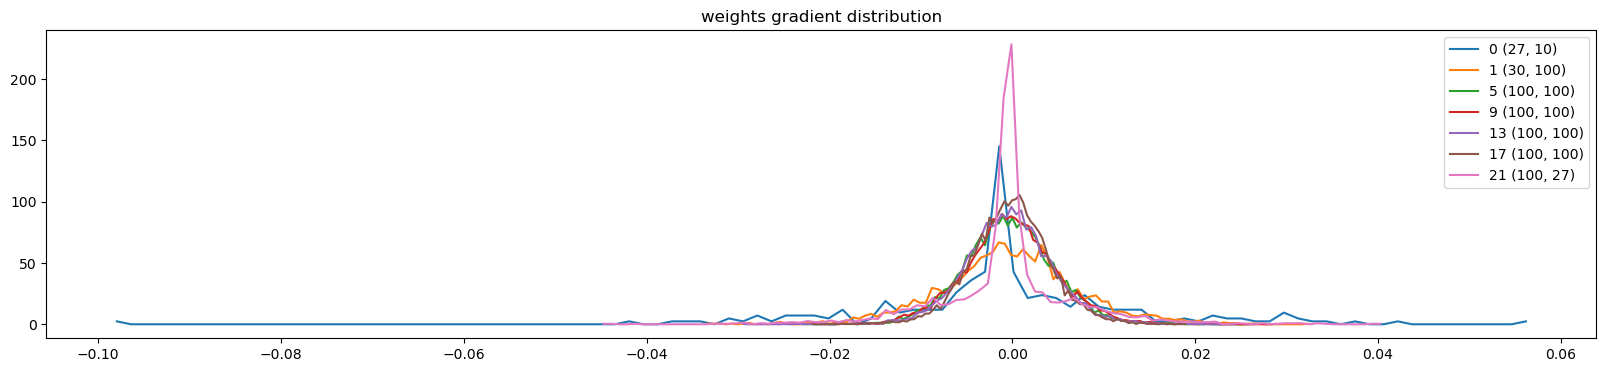

In [52]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

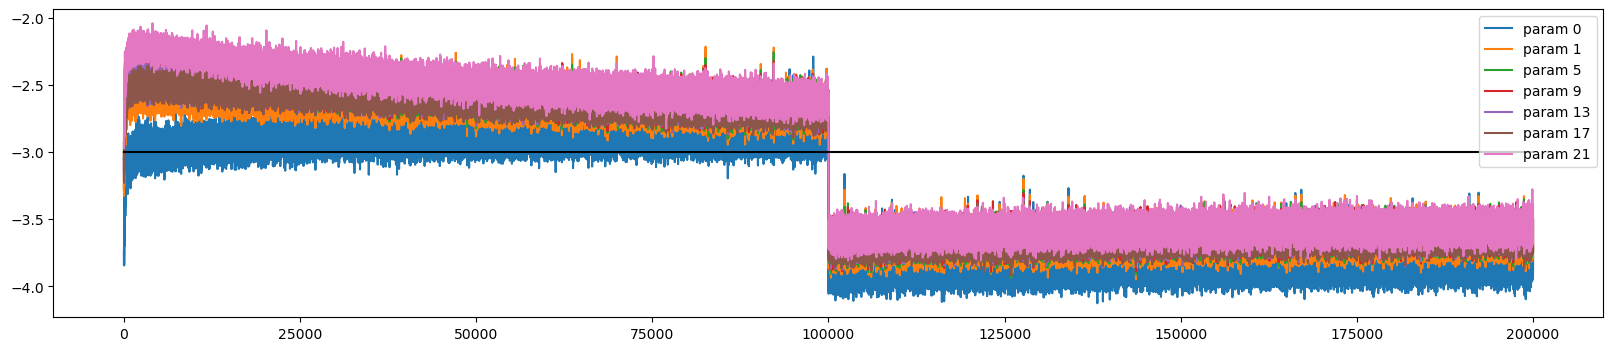

In [53]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
